<h1>Simulate net units as having neural variability</h1>

We are interested in comparing the fit of a CNN and a neuron to a model. Even if the neuron and CNN unit have the same tuning in expectation the neuron will always have a worse fit to the model because it is stochastic. It is difficult to determine what the fit of a neuron would have been absent noise, it is simpler to estimate the fit of the CNN unit under the condition of neural-like distribution of responses. Neural variability is often thought to be Poisson, lets check if that holds for our shape responses.

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as  l
import os, sys
top_dir = os.getcwd().split('ipython_nb')[0]
sys.path.append(top_dir + 'xarray')
top_dir = top_dir+ 'v4cnn/'
sys.path.append(top_dir)
sys.path.append(top_dir + 'common')
import xarray as xr
import pandas as pd
%matplotlib inline

v4_resp_mean = xr.open_dataset(top_dir + 'data/responses/V4_362PC2001.nc')['resp'].load()
v4_resp_trials = xr.open_dataset(top_dir + 'data/responses/apc_orig/apc370_with_trials.nc')
v4_resp_trials = v4_resp_trials['resp'].load().transpose('shapes','unit','trials')
v4_resp_trials = v4_resp_trials.loc[v4_resp_mean.coords['shapes'].values, :, :]

cnn_names =['bvlc_reference_caffenetAPC362_pix_width[32.0]_pos_(64.0, 164.0, 51)',]
da = xr.open_dataset(top_dir + 'data/responses/' + cnn_names[0] + '.nc')['resp']
da = da.sel(unit=slice(0, None, 1)).squeeze()
middle = np.round(len(da.coords['x'])/2.).astype(int)
da_0 = da.sel(x=da.coords['x'][middle])
da_0 = da_0.loc[v4_resp_mean.coords['shapes'].values, 96:96*2]
print(da_0)

<xarray.DataArray 'resp' (shapes: 362, unit: 97)>
array([[   -0.        ,    -0.        ,   596.81433105, ...,
           67.90952301,     6.31542063,   620.24414062],
       [    7.73518085,    -0.        ,     5.23654079, ...,
            7.69387913,    -0.        ,    50.7091217 ],
       [   52.41675949,    -0.        ,  1061.53137207, ...,
           54.32403946,     1.72336459,    52.41675949],
       ..., 
       [    7.73518085,    -0.        ,     5.23654079, ...,
            7.69387913,    -0.        ,   114.86078644],
       [    7.73518085,    -0.        ,     5.23654079, ...,
            7.69387913,    -0.        ,    71.27693939],
       [   13.43900967,    -0.        ,    35.65762711, ...,
           12.41481018,    -0.        ,   188.59216309]], dtype=float32)
Coordinates:
    layer_unit   (unit) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
    x            float64 116.0
    layer        (unit) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    y   

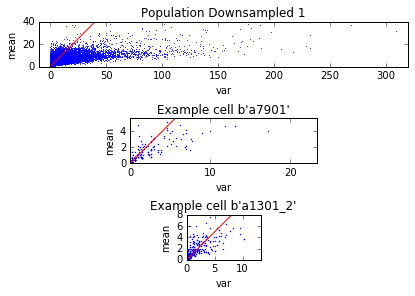

In [284]:
ax = plt.subplot(311)
ds = 1
cell_var = v4_resp_trials.var('trials',skipna=True).values.ravel()
cell_mean = v4_resp_trials.mean('trials',skipna=True).values.ravel()
ax.scatter(cell_var[::ds], cell_mean[::ds], s=1, lw=0)
ax.set_xlabel('var');ax.set_ylabel('mean');
plt.gca().set_aspect('equal', 'box-forced')
ax.plot([0,50],[0,50],color='r');ax.set_xlim(-10,320);ax.set_ylim(0,40);
ax.set_yticks([0,20,40]);
ax.set_title('Population Downsampled ' +str(ds))

ax = plt.subplot(312);
ex_cell = 50
cell_var = v4_resp_trials[:,ex_cell,:].var('trials',skipna=True)
cell_mean = v4_resp_trials[:,ex_cell,:].mean('trials',skipna=True)
ax.scatter(cell_var, cell_mean, s=2, lw=0)
ax.set_xlabel('var');ax.set_ylabel('mean');
plt.gca().set_aspect('equal', 'box-forced')
greatest = max([np.max(cell_mean),np.max(cell_var)])
ax.plot([0,greatest],[0,greatest],color='r');
ax.set_ylim(0, max(cell_mean));ax.set_xlim(0, max(cell_var))
plt.locator_params(nbins=4)
ax.set_title('Example cell '+ str(cell_var.coords['w_lab'].values))

ax = plt.subplot(313);
ex_cell = 0
cell_var = v4_resp_trials[:,ex_cell,:].var('trials',skipna=True)
cell_mean = v4_resp_trials[:,ex_cell,:].mean('trials',skipna=True)
ax.scatter(cell_var, cell_mean, s=2, lw=0)
ax.set_xlabel('var');ax.set_ylabel('mean');
plt.gca().set_aspect('equal', 'box-forced')
greatest = max([np.max(cell_mean),np.max(cell_var)])
ax.plot([0,greatest],[0,greatest],color='r');
ax.set_ylim(0, max(cell_mean));ax.set_xlim(0, max(cell_var))
plt.locator_params(nbins=4)
ax.set_title('Example cell '+ str(cell_var.coords['w_lab'].values))
plt.tight_layout()


Clearly the cells as a population do not follow Poisson variability where mean is equal to variance. It would seem many are both under and overdispersed. Overdispersion could be accounted for by a negative binomial distribution, I am not sure what distribution would account for under dispersion.
It is clear there is some relationship between mean and variance, but it does not easily fall on a line. It would seem that variability is stimuli tuned.
Given that we are performing our measurement on the means of the responses, the central limit theorem would suggest we could fit the distribution of responses well with a Gaussian.

Our model of neural responses will be:

$$R_i = \frac{1}{n}\sum_j^n{r_{ij}}$$

Where $j$ indexes the $n$ IID trials of responses to a shape, and $i$ indexes over the $s$ shapes. To begin with we assume the $r$ are $IID$ with $E[r_i] = \mu_i$ and $Var[r_i] = \sigma_{r \ i}^2$ thus


$$\sigma_i^2 = \frac{\sigma_{r \ i}^2}{n} = Var[\frac{1}{n}\sum_j^n{r_{ij}}]$$

Our fits will be on mean substracted values whose total variance on a given trial will be:
$$\sum_i^n{( R_i - \frac{1}{n} \sum_i^n{R_i} )^2}$$

Lets first determine the variance in expectation. We will find it is seperable into two components of $\mu_i$ and $\sigma_i^2$. In simulation scaling the $\sigma_i$ component we can make it such that in expectation the ratio between the variance composed of $\mu$ and $\sigma^2$ matches its estimate from neural recordings.

The facts we will need to do this are:
* $E[R_i] = \mu_i$
* $Var[R_i] = \frac{1}{n} \sigma_{r \ i}^2$ for convenience we will just call this $\sigma_i^2$
* $E[X^2] = Var[X] + E[X]^2$
* $E[XY] = E[X]E[Y] \ \ (X,Y \  independent)$


$$Var = E[\sum_i^s{( R_i - \frac{1}{s} \sum_g^s{R_g} )^2}]$$

$$= \sum_i^s{E[( R_i - \frac{1}{s} \sum_g^s{R_g} )( R_i - \frac{1}{s} \sum_g^s{R_g} )}]$$

$$= \sum_i^s{E[R_i^2  - \frac{2}{s} R_i\sum_g^s{R_g} + \frac{1}{s^2} \sum_g^s{R_g} \sum_g^s{R_g}]} $$

$$= \sum_i^s{(E[R_i^2]  - \frac{2}{s} E[R_i\sum_g^s{R_g}] + \frac{1}{s^2}E[\sum_g^s{R_g} \sum_g^s{R_g}])} $$

$$= \sum_i^s{E[R_i^2]}  - \frac{2}{s}\sum_i^s{ E[R_i\sum_g^s{R_g}]} + \frac{1}{s^2}\sum_i^s{E[\sum_g^s{R_g} \sum_g^s{R_g}]} $$

Now lets look at each of these terms in turn:

1) 

$$\sum_i^s{E[R_i^2]} $$
$$\sum_i^s{(\sigma_i^2 + \mu_i^2)}$$

2) 

$$- \frac{2}{s}\sum_i^s{ E[R_i\sum_g^s{R_g}]} $$
$$- \frac{2}{s}\sum_i^s{ E[R_i^2 + R_i \sum_{g \neq i}^{s-1}{R_g}]} $$
$$- \frac{2}{s}\sum_i^s{ (\sigma_i^2 + \mu_i^2  + \mu_i \sum_{g \neq i}^{s-1}{\mu_g})} $$
$$- \frac{2}{s}\sum_i^s{ (\sigma_i^2  + \mu_i \sum_{g}^{s}{\mu_g})} $$


3) 

$$\frac{1}{s^2} \sum_i^s{E[\sum_g^s{R_g} \sum_g^s{R_g}]}$$
$$\frac{s}{s^2} \sum_i^s{(\sigma_i^2  + \mu_i \sum_{g}^{s}{\mu_g})}$$
$$\frac{1}{s} \sum_i^s{(\sigma_i^2  + \mu_i \sum_{g}^{s}{\mu_g})}$$

Combining these back together:

$$Var = \sum_i^s{(\sigma_i^2 + \mu_i^2)} - \frac{2}{s}\sum_i^s{ (\sigma_i^2  + \mu_i \sum_{g}^{s}{\mu_g})}  +  \frac{1}{s} \sum_i^s{(\sigma_i^2  + \mu_i \sum_{g}^{s}{\mu_g})}$$

$$= \sum_i^s{(\sigma_i^2 + \mu_i^2)} - \frac{1}{s}\sum_i^s{ (\sigma_i^2  + \mu_i \sum_{g}^{s}{\mu_g})} $$

$$= \sum_i^s{(\sigma_i^2 + \mu_i^2)} - \frac{1}{s}\sum_i^s{(\sigma_i^2 + \mu_i^2  + \mu_i \sum_{g \neq i}^{s-1}{\mu_g})} $$

$$= \sum_i^s{(\sigma_i^2 + \mu_i^2)} - \frac{1}{s}\sum_i^s{(\sigma_i^2 + \mu_i^2)}  - \frac{1}{s} \sum_i^s{(\mu_i \sum_{g \neq i}^{s-1}{\mu_g})} $$

$$= \frac{s-1}{s}\sum_i^s{(\sigma_i^2 + \mu_i^2)}  - \frac{1}{s} \sum_i^s{(\mu_i \sum_{g \neq i}^{s-1}{\mu_g})} $$

$$= \frac{s-1}{s}\sum_i^s{\sigma_i^2} + \frac{s-1}{s}\sum_i^s{\mu_i^2}  - \frac{1}{s} \sum_i^s{(\mu_i \sum_{g \neq i}^{s-1}{\mu_g})} $$

We will need to estimate $\sigma_i^2$ and an unbiased estimator of it is the sample variance:

$$\hat{\sigma}_{r \ i}^2 = \frac{1}{n-1} \sum_j^n{(r_{ij} - \frac{1}{n}\sum_j^n{r_{ij}})^2} $$

dividing this by n gives us the variance of the mean.
$$\hat{\sigma}_{i}^2 = \frac{1}{n^2-n} \sum_j^n{(r_{ij} - \frac{1}{n}\sum_j^n{r_{ij}})^2} $$

Now lets make sure that our formula for expected variance works.

Expected Variance Value 554.5
Average Variance Value:553.47


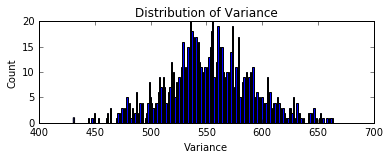

In [231]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
n = 5 #trials
s = 370 #stimuli
n_exps = 1000 #number simulations
sigma = np.array([5,]*s) # the variance of each trial

#each trial for a stimuli has the same expectation
mu = np.cos(np.linspace(0, np.pi, s)) + 1 #s

#lets calculate our expectation from the formula derived above
sigma_R = (sigma/n) #averaging trials reduces variance.

#mean of each entry in our mean stimuli response matrix is the signal variation
mu_cross = (np.expand_dims(mu, 0) * np.expand_dims(mu, 1))#outer product of mus
mu_sqrd_sum = np.sum(mu_cross) - np.trace(mu_cross)#sum these minus the trace
mu_var = ((s-1)/s)*np.sum(mu**2) - (1/s)*mu_sqrd_sum#subtract the mu outer product from sum of squared mu

#the noise variance which is independent of the mean variance is added to this
noise_var = ((s-1)/s)*np.sum(sigma_R)
expectation = mu_var + noise_var

print('Expected Variance Value ' + str(np.mean(expectation)))

r = np.random.normal(loc=mu, scale=np.sqrt(sigma), size=(n_exps, n, s)) # nx n s
R = r.mean(1) # nx s
R_ms = R - R.mean(1, keepdims=True)# nx s
var = np.sum(R_ms**2, 1)
print('Average Variance Value:' + str(np.round(np.mean(var),2)))
ax = plt.subplot(211)
_ = plt.hist(var, bins=200)
_ = plt.title('Distribution of Variance');
_ = ax.set_xlabel('Variance');_ = ax.set_ylabel('Count')

<h5>SNR</h5>
$$\frac{\sigma^2_{signal}}{\sigma^2_{noise}}$$

Previously we determined the variance of our experiment could be decomposed as such:

$$\frac{s-1}{s}\sum_i^s{\sigma_i^2} + \frac{s-1}{s}\sum_i^s{\mu_i^2}  - \frac{1}{s} \sum_i^s{(\mu_i \sum_{g \neq i}^{}{\mu_g})} $$

For simulating neural variability we would like the variance of simulations to have the same ratio of the first term (noise) to the second two (signal).

$$\frac{\sigma^2_{signal}}{\sigma^2_{noise}} = \frac {\frac{s-1}{s}\sum_i^s{\mu_i^2}  - \frac{1}{s} \sum_i^s{(\mu_i \sum_{g \neq i}^{}{\mu_g})}}{\frac{s-1}{s}\sum_i^s{\sigma_i^2}} $$

To evaluate this ratio for a neuron I first tried substituting in these estimates:
$$\hat{\mu}_i = R_i = \frac{1}{n}\sum_j^n{r_{ij}}$$
$$\hat{\sigma}_i^2 = \frac{1}{n^2-n} \sum_j^n{(r_{ij} - \frac{1}{n}\sum_j^n{r_{ij}})^2} $$

I then realized that these estimates do not result in an unbiased estimator for the numerator. For the first term in the numerator squaring $\hat{\mu}$ results in the variance also gettting added in and $\frac{1}{n}$ in the sample mean becomes squared  and the cross products between means also gets added in.

To correct this we estimate the sum of squared means by summing the sqaured trials dividing by n, and subtracting off the estimated variance.
$$\hat{\mu}_i^2 = \frac{1}{n} \sum_j^n{x_i^2} - \frac{1}{n-1} \sum_j^s{(x_j-\bar{x})^2}$$

Now lets make sure each of these terms is being estimated faithfully.

Sum of variances: 6.0
Sum of cross product means: 84.5
Sum of mean squared: 15.5
SNR: 1.019
Average estimated sum of variances: 6.004
Average estimated sum of cross product means: 84.725
Average estimated sum of mean squared: 15.48
Average estimated SNR: 1.121
SNR from average estimates: 1.01


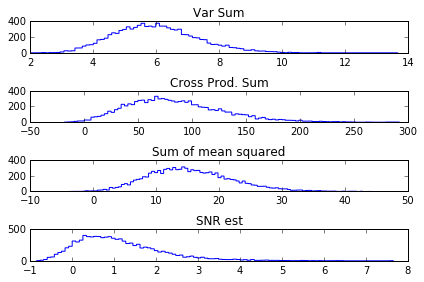

In [283]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 16 14:52:03 2017

@author: deanpospisil
"""
import numpy as np
#first we perform an experiment
n = 5 #trials
s = 10 #stimuli
n_exps = 10000 #number simulations
sigma = np.array([3,]*s) # the variance of each trial

#each trial for a stimuli has the same expectation
neuron_mu = np.cos(np.linspace(0, np.pi, s)) + 1 #s

#calc var_sum
sigma_R = (sigma/n) #averaging trials reduces variance.
var_sum = np.sum(sigma_R)

#sum of mu^2                    
mu_sqrd_sum = np.sum(neuron_mu**2)

#cross products of mu's
cross_prod = ((np.expand_dims(neuron_mu, 0) * np.expand_dims(neuron_mu, 1)))
cross_prod_sum = np.sum(cross_prod) - np.sum(np.trace(cross_prod))

snr = (((s-1)/s)*mu_sqrd_sum - (1/s)*cross_prod_sum) /(((s-1)/s)*var_sum)


print('Sum of variances: '+ str(var_sum))
print('Sum of cross product means: ' + str(cross_prod_sum))
print('Sum of mean squared: ' + str(mu_sqrd_sum))
print('SNR: ' + str(np.round((snr), 3)))


#we then perform our experiments
r = np.random.normal(loc=neuron_mu, scale=np.sqrt(sigma), 
                     size=(n_exps, n, s)) # nx n s

#calc var_sum
est_neuron_sig = np.var(r, 1, ddof=1) #nx s
est_sigma_R = est_neuron_sig/n #averaging trials reduces variance.
est_var_sum = np.sum(est_sigma_R, 1)
                     
#sum of mu^2                    
est_neuron_sig = np.var(r, 1, ddof=1) #nx s
est_neuron_mu2 = np.mean(r**2, 1)# nx s
est_neuron_mu2 -= est_neuron_sig
est_mu_sqrd_sum = est_neuron_mu2.sum(1)

#cross products of mu's
est_mu = np.mean(r, 1)
est_cross_prod = (np.expand_dims(est_mu, 1) * np.expand_dims(est_mu, 2))#outer product of mus
est_cross_prod_sum = np.sum(est_cross_prod, axis=(1,2)) - np.trace(est_cross_prod, axis1=1, axis2=2)

est_snr = (((s-1)/s)*est_mu_sqrd_sum - (1/s)*est_cross_prod_sum) /(((s-1)/s)*est_var_sum)

print('Average estimated sum of variances: ' + str(np.round(np.mean(est_var_sum), 3)))
print('Average estimated sum of cross product means: ' + str(np.round(np.mean(est_cross_prod_sum), 3)))
print('Average estimated sum of mean squared: ' + str(np.round(np.mean(est_mu_sqrd_sum), 3)))
print('Average estimated SNR: ' + str(np.round(np.mean(est_snr), 3)))

snr_from_avg_est = (((s-1)/s)*np.mean(est_mu_sqrd_sum) - (1/s)*np.mean(est_cross_prod_sum)) /(((s-1)/s)*np.mean(est_var_sum))
print('SNR from average estimates: ' + str(np.round(np.mean(snr_from_avg_est), 3)))

ax = plt.subplot(411)
_ = ax.hist(est_var_sum, histtype='step', bins=100);ax.set_title('Var Sum');
plt.locator_params(nbins=2, axis='y')
ax = plt.subplot(412)
_ = ax.hist(est_cross_prod_sum, histtype='step', bins=100);ax.set_title('Cross Prod. Sum');
plt.locator_params(nbins=2, axis='y')
ax = plt.subplot(413)
_ = ax.hist(est_mu_sqrd_sum, histtype='step', bins=100);ax.set_title('Sum of mean squared');
plt.locator_params(nbins=2, axis='y')
plt.tight_layout()

ax = plt.subplot(414)
_ = ax.hist(est_snr, histtype='step', bins=100);ax.set_title('SNR est');
plt.locator_params(nbins=2, axis='y')
plt.tight_layout()

The estimator of SNR is still biased, even though all of its constituents are unbiased. What is likely going on is the substraction of variance in the numerator is dependent with the variances in the denominator. When variance on bottom is large, more variance gets subtracted from the top. Need to think more about whether I can find its result in expecation to unbias it.

Now with our SNR estimate we need to take the responses from a CNN and determines the variance for each shape response so that the response vector as a whole matches the SNR of a typical neuron.

We assume the mean of the distribution are the actual responses of the CNN thus we know the numerator of the SNR, all that remains is to solve for the scaling of the denominator:

$$\sigma^2_{noise \ CNN} = \frac{s-1}{s}\sum_i^s{\hat{\sigma}_i^2} $$
$$\sigma^2_{signal \ CNN} = \frac{s-1}{s}\sum_i^s{\hat{\mu}_i^2}  - \frac{1}{s} \sum_i^s{(\hat{\mu}_i \sum_{g \neq i}^{}{\hat{\mu}_g})}$$
$$\hat{\mu}_i = R_i = \frac{1}{n}\sum_j^n{r_{ij}}$$
$$\hat{\sigma}_i^2 = \frac{1}{n^2-n} \sum_j^n{(r_{ij} - \frac{1}{n}\sum_j^n{r_{ij}})^2} $$

$$ SNR_{neuron} = \frac{\sigma^2_{signal \ CNN}}{\sigma^2_{noise \ CNN}}$$

$$\frac{\sigma^2_{signal \ CNN}}{SNR_{neuron}}  = \sigma^2_{noise \ CNN} $$

Thus the form of our CNN 'neural-like' distribution will be $N(\mu_i, \  a_i \ \sigma^2_{noise \ CNN})$ where $\sum{a_i} = 1$. We then must determine what $a_i$ to use, i.e. how to distibute our variances across our shape responses.

One option would be homoscedasticity (i.e. all equal variance):
$$a_i = \frac{1}{n}$$


another would be to make them heteroscedastic (i.e. not equal).
Heteroscedascity would be more neural-like given we saw some tendency for neural responses  to increase their variance with a higher mean. Given that higher responses tend to have more leverage on a least squares fit their variance should be more damaging to a model fit. It might be reasonable then to make the comparison more fair by scaling the variance to the means. 

$$a_i = \frac{|\mu_i|}{\sum{|\mu_i|}}$$

We use the absolute value of the mean because in the CNN some responses are negative but $\sigma$ is not.

Lets begin by evaluating the homoscedastic case to see how well the whole idea works in the ideal case. We take a neuron and a CNN unit with the same expected values (thus same correlation to model). 

In [233]:
#first lets calculate the SNR for one of our neurons
ex_cell = 0
r = v4_resp_trials[:,ex_cell,:].dropna('trials', how='all')
s = r.shape[0]
n = r.shape[1]
print(r.coords['w_lab'].values)
print(r)
#for each experiment on a neuron we estimate its SNR
est_neuron_mu = r.mean('shapes')
mu_var = mu_var_calc(est_neuron_mu.values)
est_neuron_sig = r.var('trials', ddof=1)/n
noise_var = ((s-1)/s)*est_neuron_sig.sum('shapes')
snr_est = mu_var/noise_var.values
print('SNR estimate: ' +  str(np.round(snr_est, 3)))

b'a1301_2'
<xarray.DataArray 'resp' (shapes: 362, trials: 5)>
array([[ 0.,  0.,  2.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  2.,  1.,  0.],
       [ 2.,  2.,  1.,  4.,  2.]])
Coordinates:
    w_lab    |S7 b'a1301_2'
  * shapes   (shapes) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 22 ...
  * trials   (trials) int64 0 1 2 3 4
    unit     int64 0
Attributes:
    dur: 850.0
    fs: 1000.0
    start: -150.0
SNR estimate: 0.092


We thus have estimated the SNR, now we need to get the same SNR for a CNN unit. For simplicity lets look at the early conv units.

In [249]:
import apc_model_fit as ac
fn = top_dir + 'data/models/' + 'apc_models_362.nc'
dmod = xr.open_dataset(fn, chunks={'models':50, 'shapes':370})['resp'].load()

apc_fit_conv1 = ac.cor_resp_to_model(da_0.chunk({'shapes': 370}), 
                                  dmod.chunk({}), fit_over_dims=None, prov_commit=False)
best_r = max(apc_fit_conv1).values

/Users/deanpospisil/anaconda3/lib/python3.5/site-packages/dask/async.py:246: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [250]:
print((apc_fit_conv1))

<xarray.DataArray (unit: 97)>
array([ 0.35659703,  0.37648215,  0.53290417,  0.42428525,  0.34701196,
        0.20922873,  0.44339882,  0.40680357,  0.47801943,  0.28886836,
        0.47157612,  0.26203422,  0.33591159,  0.26796747,  0.40345356,
        0.33701056,  0.38043992,  0.40310089,  0.33199802,  0.34307737,
        0.31124972,  0.3515457 ,  0.313747  ,  0.30237269,  0.58819488,
        0.42085159,  0.52732943,  0.28247037,  0.43073745,  0.47048327,
        0.40062892,  0.39873236,  0.44333014,  0.50753118,  0.49137688,
        0.20147162,  0.36178329,  0.26444178,  0.25333522,  0.36034532,
        0.2918333 ,  0.29683369,  0.56845877,  0.38015777,  0.43039876,
        0.53955862,  0.40612723,  0.38982607,  0.50935733,  0.33216025,
        0.22999325,  0.47130047,  0.23112618,  0.2631271 ,  0.41662152,
        0.35980058,  0.45385302,  0.45739816,  0.47702801,  0.35769472,
        0.33577722,  0.18954225,  0.33778413,  0.56104407,         nan,
        0.21734676,  0.35338561,  

We find a surprisingly high correlation for the max value of an early conv unit. For this particular unit and model, lets see how their correlation changes with the same SNR as a neuron.

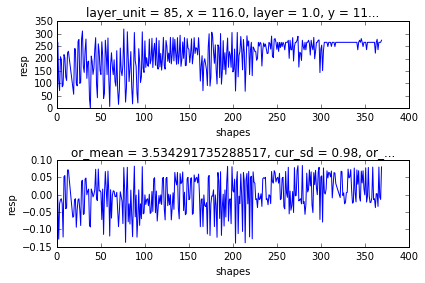

In [279]:
best_unit_ind = apc_fit_conv1.argmax().values
ex_unit = da_0[:, int(best_unit_ind)]
best_mod_ind = max(apc_fit_conv1).coords['models'].values
best_mod = dmod[:, int(best_mod_ind)]
ax = plt.subplot(211)
ex_unit.plot()
ax = plt.subplot(212)
best_mod.plot();plt.tight_layout()

Lets now try adding Poisson noise first. We will scale this rectified unit to the same mean as our 109 V4 cells, then assume it is Poisson distributed.

In [280]:
#trials were 500 ms long
mean_v4 = v4_resp_trials.mean(['trials', 'shapes'])*2
print(mean_v4.to_pandas().describe())

count    109.000000
mean       8.054115
std        5.700593
min        0.809076
25%        3.534034
50%        6.681793
75%       11.410072
max       26.725223
dtype: float64


Here we have the mean responses of each cell to our stimuli summarized, lets go with the average for now.

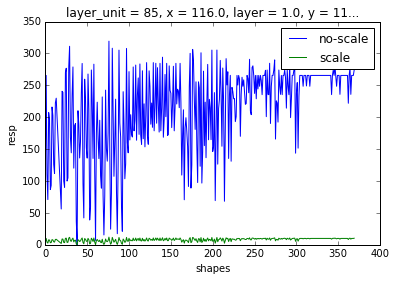

In [281]:
tot_mean_v4 = mean_v4.mean()
ex_unit.plot()
ex_unit = (tot_mean_v4/ex_unit.mean())*ex_unit
ex_unit.plot()
plt.legend(['no-scale','scale'])


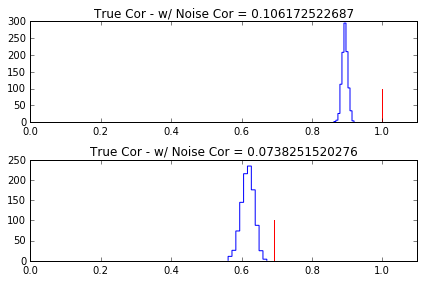

In [254]:
nx = 1000
n = 5
r = np.random.poisson(ex_unit.values, size=(nx, n, len(ex_unit.values)))
R = r.mean(1)
cor_w_self = [np.corrcoef(an_exp, ex_unit.values)[0,1] for an_exp in R]
ax = plt.subplot(211)
_=ax.hist(cor_w_self, histtype='step')
ax.set_xlim(0,1.1)
ax.plot([1, 1], [0,100], color='r')

ax.set_title('True Cor - w/ Noise Cor = '+str(1-np.mean(cor_w_self)))
ax = plt.subplot(212)
cor_w_model = [np.corrcoef(an_exp, best_mod)[0,1] for an_exp in R]
_=ax.hist(cor_w_model, histtype='step')
ax.plot([best_r, best_r], [0,100], color='r')
#ax.plot([np.mean(cor_w_model),]*2, [0,100], color='g')
ax.set_xlim(0,1.1);
ax.set_title('True Cor - w/ Noise Cor = '+str(best_r-np.mean(cor_w_model)))
plt.tight_layout()

Now lets do this for a subset of the AlexNet units (early layer) and see how it shifts them relative to V4

In [262]:
nx = 100
n = 5
mean_cor = []
for i, fit in enumerate(apc_fit_conv1):
    ex_unit = da_0[:, i]
    mod_ind = fit.coords['models'].values
    mod = dmod[:, int(mod_ind)]

    ex_unit = (tot_mean_v4/ex_unit.mean())*ex_unit
    r = np.random.poisson(ex_unit.values, size=(nx, n, len(ex_unit.values)))
    R = r.mean(1)
    mean_cor.append(np.mean([np.corrcoef(an_exp, mod)[0,1] for an_exp in R]))

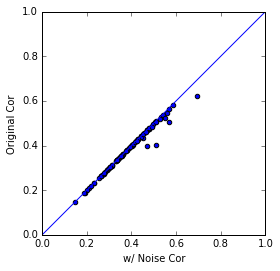

In [264]:
plt.scatter(apc_fit_conv1.values, mean_cor)
plt.xlabel('w/ Noise Cor')
plt.ylabel('Original Cor')
plt.title('')
plt.gca().set_aspect('equal', 'box-forced')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1])

It would seem that making the unit Poisson like influences some units more than others, while not being particularly dependent on the original correlation. Whats going on? Well lets look at the original responses we scaled down for the next unit.

<xarray.DataArray ()>
array(79)
Coordinates:
    layer_unit   int32 1
    x            float64 116.0
    layer        float64 1.0
    y            float64 114.0
    scale        float64 8.41
    layer_label  |S5 b'relu1'
    unit         int64 97
    or_mean      float64 3.142
    cur_sd       float64 0.2886
    or_sd        float64 0.4014
    cur_mean     float64 0.9
    models       int64 47118


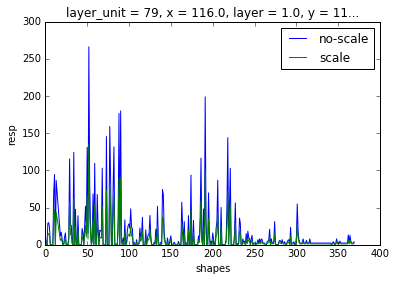

In [277]:
print(apc_fit_conv1.argsort()[1])
ex_unit = da_0[:,int(apc_fit_conv1.argsort()[1].values)]
ex_unit.plot()
ex_unit = (tot_mean_v4/ex_unit.mean())*ex_unit
ex_unit.plot()
plt.legend(['no-scale','scale'])

The problem seems to be that depending upon the original response profile of the unit this then influences how much it will get corrupted by Poisson noise. We are not interested in this interaction, we are interested in whether if similar amounts of noise were added 